In [ ]:
%pip install torch matplotlib


In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)


32033

In [185]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [202]:
import random

block_size = 3


def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))


Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182484, 3]) torch.Size([182484])
torch.Size([22869, 3]) torch.Size([22869])
torch.Size([22793, 3]) torch.Size([22793])


In [226]:
words[:5], Xtr[:5], Ytr[:5]

(['jayriel', 'jaxlynn', 'oaklee', 'daly', 'paden'],
 tensor([[ 0,  0,  0],
         [ 0,  0, 10],
         [ 0, 10,  1],
         [10,  1, 25],
         [ 1, 25, 18]]),
 tensor([10,  1, 25, 18,  9]))

In [203]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [204]:
sum(p.nelement() for p in parameters)

11897

In [205]:
for p in parameters:
    p.requires_grad = True


In [206]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [207]:
lri = []
lossi = []
stepi = []

In [216]:
for i in range(50000):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32, ))

    # forward pass
    emb = C[Xtr[ix]]  # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
    logits = h @ W2 + b2  # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())


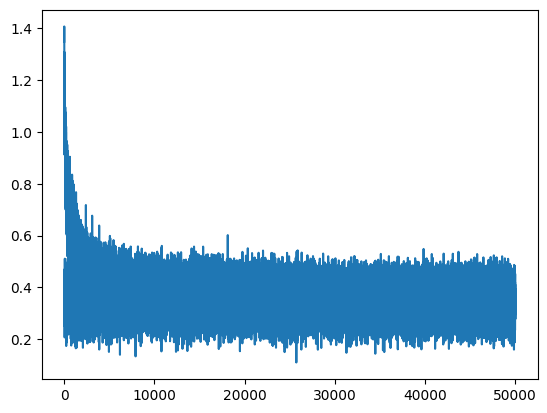

In [217]:
plt.plot(stepi, lossi)

In [218]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1311, grad_fn=<NllLossBackward0>)

In [219]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1673, grad_fn=<NllLossBackward0>)

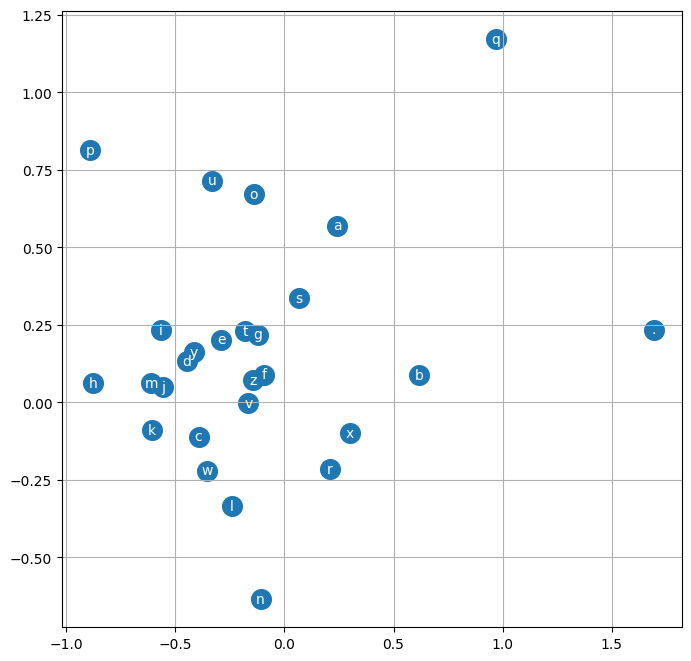

In [220]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax()
